In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
import pickle as pkl

import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights, Qmake_discriminator, VAE_GAN_Model
from data_and_eval_utils import load_preprocessed_snl, plot_rocs, calc_anomaly_dist, AD_score_KL, AD_score_CKL, get_truth_and_scores, eval_rocs
# from models import VAE_Model_ATLAS_beta as NNmodel


# # Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[3], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [2]:
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
SAVE_PATH = home_path+f"/GAN_trainings/" 

### Loss plots.

In [3]:
# History Keys
keys = [
        'loss'               # VAE total loss term.
        ,'reco_loss'         # VAE loss term
        ,'kl_loss'           # VAE Loss term
        ,'disc_loss'         # VAE loss due to discriminator "failure to fool disc"
        # # ,'raw_loss'          # Reco_loss + kl_loss
        ,'w_kl_loss'         # kl_loss * beta
        ,'w_disc_loss'       # disc_loss * gamma
        ,'d_loss'
        # Validation version
        ,'val_loss'          
        ,'val_reco_loss'
        ,'val_kl_loss'
        ,'val_disc_loss'
        # ,'val_raw_loss'
        ,'val_w_kl_loss'
        ,'val_w_disc_loss'
        ,'val_d_loss'
        # --
        # ,'beta'              # hyperparameter
        # ,'gamma'             # hyperparameter
        # ,'val_gamma'         # hyperparameter
        # ,'val_beta'          # hyperparameter
        # ,'lr'              # learning rate
        ]

color_key = {
             'loss' : 'k'               # VAE total loss term.
            ,'val_loss' : 'k'         
            ,'reco_loss': 'tab:blue'         # VAE loss term
            ,'val_reco_loss' : 'tab:blue'
            ,'kl_loss': 'crimson'          # VAE Loss term
            ,'val_kl_loss': 'crimson'
            ,'disc_loss' : 'c'        # VAE loss due to discriminator "failure to fool disc"
            ,'val_disc_loss' : 'c'
            ,'w_kl_loss'  : 'tab:orange'        # kl_loss * beta
            ,'val_w_kl_loss' : 'tab:orange'
            ,'w_disc_loss'  : 'tab:green'     # disc_loss * gamma
            ,'val_w_disc_loss' : 'tab:green'
            ,'d_loss': 'r'
            ,'val_d_loss' :'r'
        }
# d_loss : discriminator loss
# loss : generator total loss
# raw_loss : reconstruction and kl_loss without beta weighting


# # Generate cleaner legend
# proxy_lines = {}
# for key in keys:
#     base_key = key.replace('val_', '')  # Strip 'val_' to group them
#     if base_key not in proxy_lines and key in color_key:
#         proxy_lines[base_key] = Line2D([0], [0], 
#                                     color=color_key[key], 
#                                     lw=2, 
#                                     label=base_key)
# clean_leg = list(proxy_lines.values())
# for att_n in range(6, 38): # plot all attempts. most recent is 18.
#     att_path = SAVE_PATH + f"attempt{att_n}/"

#     # Make folder for loss plots if it doesn't exist
#     plot_dir = os.path.join(SAVE_PATH, f"loss_plots/attempt{att_n}/")
#     os.makedirs(plot_dir, exist_ok=True)
    
#     for i in range(10): # Currently only training 10 models at a time.
#         save_path = att_path + f"n_{i}/"
#         with open(save_path + 'training_history.pkl', 'rb') as f:
#             history = pkl.load(f)
    
        
#         # Plot training losses
#         # fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,10))
#         fig = plt.figure(figsize=(12, 8))
#         gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 3:1 means top gets 75%, bottom 25%

#         ax = fig.add_subplot(gs[0])
#         ax2 = fig.add_subplot(gs[1], sharex=ax)

#         # Calculate fractional contributions to total VAE loss
#         loss = np.array(history['loss'])
#         reco_loss = np.array(history['reco_loss'])
#         beta = np.array(history['beta'])
#         reco_loss_frac = (reco_loss * (1 - beta))/loss

#         w_kl_loss_frac = np.array(history['w_kl_loss'])/loss
#         w_disc_loss_frac = np.array(history['w_disc_loss'])/loss
#         ax2.plot(reco_loss_frac, label='reco_loss_frac')
#         ax2.plot(w_kl_loss_frac, label='w_kl_loss_frac')
#         ax2.plot(w_disc_loss_frac, label='w_disc_loss_frac')

#         # Tweak fractional plot
#         # ax2.set_ylim((0,1))
#         ax2.set_ylabel('Approximate\nTotal VAE Loss fraction')
#         # ax2.tick_params(axis='y', labelcolor='b')
#         ax2.legend()
#         ax2.grid()
#         ax2.set_xlabel('Epoch')

#         for key in keys:
#             if key == 'lr' or history.get(key) == None:
#                 continue
#             ax.plot(np.abs(history[key]),
#                      label=key, 
#                      linestyle = "dashed" if key[0:3] == 'val' else "solid",
#                      marker= "x" if key[0:3] == 'val' else "o",
#                      markersize=6.5,
#                      color=color_key[key])
    
#         # Customize the plot
#         ax.set_title(f'Training and Validation Losses, Attempt: {att_n} Run: {i}')
#         ax.set_ylabel('Loss')
#         # ax.tick_params(axis='y', labelcolor='r')
#         # ax.legend()
#         ax.grid(True)
#         ax.set_yscale('log')
#         ax.legend(handles=clean_leg, title="○ = train, x = val")
#         plt.savefig(SAVE_PATH + f"loss_plots/attempt{att_n}/" + f"loss_attempt_{att_n}_run_{i}.png", bbox_inches='tight')
#         # plt.show()
#         plt.close(fig)
#     print(f"Attempt {att_n} plotting complete!")

In [4]:
# Load data
data = load_preprocessed_snl()
# X_train = data['X_train']

Data loaded from preprocessed_SNL_data.h5


##### Calculate Anomaly scores

In [5]:
from pathlib import Path

TRAIN = False
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_TRAIN = 10 # number of trained models
bad_models = []
SAVE_FIG = True
FILE_NAMES = ""
FIG_SAVE_PATH = SAVE_PATH + "plots/"



After inspecting the graphs a few notable models remain

In [6]:
 # mins 88, 90, 89, 79 for AUC. 
# # 16 did the best AUC and I think also has higher TPR @ target FPR

Anamoly Score Distribution

In [7]:
new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_disc = Qmake_discriminator(INPUT_SZ, 8, 2)
new_VAE = VAE_GAN_Model(new_enc, new_dec, new_disc)
save_path = SAVE_PATH + "attempt38/"f"n_{4}/" # 5 for CKL VAE-GAN

new_VAE.load_weights(save_path)

just_enc = new_VAE.get_layer("encoder") # We only need encoder output


2025-08-08 12:32:31.038369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


10642/10642 [==============================] - 6s 598us/step


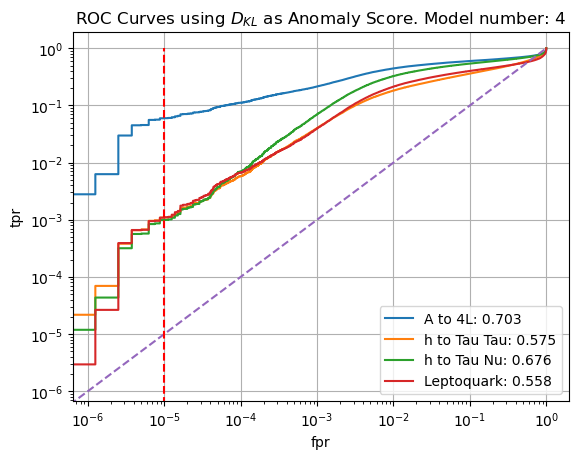

We good. All Tresholds match
Treshold at Target: 584.1487046419388
A to 4L TPR @ FPR 10e-5 (%): 5.96

h to Tau Tau TPR @ FPR 10e-5 (%): 0.11

h to Tau Nu TPR @ FPR 10e-5 (%): 0.10

Leptoquark TPR @ FPR 10e-5 (%): 0.11



In [12]:
# t, s, bad_model = get_truth_and_scores(just_enc, AD_score_CKL, data)
# if bad_model:
#     print(f"Unstable mode. Inf encountered. Model number {i} ")
#     # bad_models.append(i)

roc_perfs = eval_rocs(just_enc, data, AD_score_CKL)

f = plot_rocs(roc_perfs, "ROC Curves using $D_{KL}$ as Anomaly Score. Model number: " + str(4))

In [ ]:

# data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data
#                , X_train
#                , X_test
#                ] # Already defined.
data_names_tex = [ # latex version
                "Leptoquark"
                , "$A\\rightarrow 4\ell$"
                , "$h^{\pm}\\rightarrow\\tau \\nu$"
                , "$h^0\\rightarrow\\tau\\tau$"
                , "Training Set (BG)" # Background
                , "Test Set (BG)" # Background
                ]

anomaly_scores = []
for _, dat in data.items():
    s = calc_anomaly_dist(dat, just_enc, AD_score_CKL)
    anomaly_scores.append(s)


In [ ]:
# plot setting for CKL
bin_n = 125
xlims = (0, 40)
ylims = (0, 0.03)
bins  = np.linspace(xlims[0], xlims[1], bin_n)
xlabel = "Clipped KL"


# # Investigating around the threshold at 161
# ckl_roc_threshold = 161.84
# bin_n = 10
# l_margin = 10 
# r_margin = 300

# xlims = ( ckl_roc_threshold - l_margin , ckl_roc_threshold + r_margin)
# ylims = (0, 0.01)
# bins  = np.linspace(xlims[0], xlims[1], bin_n)
# xlabel = "Clipped KL"

# Plot settings for KL
# bin_n = 125
# xlims = (0, 40)
# ylims = (0, 0.0125)
# bins  = np.linspace(0, xlims[1], bin_n)
# xlabel = "KL Divergence"

for i in range(len(data_names_tex)):
    dat = anomaly_scores[i]
    # print(bin_n)
    plt.hist(dat
             , bins = bins
             , label=data_names_tex[i] # + " " + str(bin_n)
             , histtype = "step"
             , density=True
             )
plt.legend(loc="upper right")
# plt.vlines(ckl_roc_threshold, 0, 1)
# plt.loglog()
# plt.semilogy()
# plt.semilogx()
plt.xlabel(xlabel)
plt.ylabel("Density")
plt.grid()
plt.ylim(ylims)
plt.xlim(xlims)
plt.title("Anomaly Score Distribution Across Datasets")